# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [81]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  72.73 sec.


In [4]:
out_dir = out_dir = '../data/out_dev/'

In [5]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 50000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
Shuffle = False
N = 50000
Taking FFT of the images:
Batch 1/10  13.76 sec.
Batch 2/10  13.65 sec.
Batch 3/10  13.66 sec.
Batch 4/10  15.10 sec.
Batch 5/10  13.67 sec.
Batch 6/10  13.66 sec.
Batch 7/10  13.66 sec.
Batch 8/10  15.21 sec.
Batch 9/10  13.81 sec.
Batch 10/10  14.38 sec.
FFT done. Time:  173.28 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.28000000e+02]
Vectorised imgs_f.shape = (50000, 16384)
Mask radius = 0.1502862595419847
Estimating the noise using the 48 x 48 corners of the first 1000 images.
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  19.36 sec.


### Only volume reconstruction for now - SGD

In [6]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [126]:
ll = loss_obj.loss_sum(v_rec, angles[:10], shifts[:10], ctf_params[:10], imgs_f[:10], sigma_noise)
ll

DeviceArray(6321.5178569, dtype=float64)

In [7]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [96]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [140]:
N_epochs = 5
batch_size = 64
step_size = 1000000 # 1e-3

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise)
#x0 = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [141]:
v_rec, loss_rec, grad_rec = sgd(grad_func, loss_func, N, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)

Epoch 1/5 

100%|██████████| 781/781 [00:45<00:00, 17.06it/s, grad=1.418e-04, loss=5940.53]


  |Grad| = 1.623e-04
  |Loss| = 5934.553
Epoch 2/5 

100%|██████████| 781/781 [00:45<00:00, 17.09it/s, grad=1.472e-04, loss=5888.04]


  |Grad| = 1.632e-04
  |Loss| = 5934.321
Epoch 3/5 

100%|██████████| 781/781 [00:45<00:00, 17.09it/s, grad=1.534e-04, loss=5889.57]


  |Grad| = 1.637e-04
  |Loss| = 5934.226
Epoch 4/5 

100%|██████████| 781/781 [00:45<00:00, 17.01it/s, grad=1.552e-04, loss=6011.52]


  |Grad| = 1.634e-04
  |Loss| = 5934.247
Epoch 5/5 

100%|██████████| 781/781 [00:46<00:00, 16.72it/s, grad=1.768e-04, loss=5896.36]


  |Grad| = 1.636e-04
  |Loss| = 5934.265


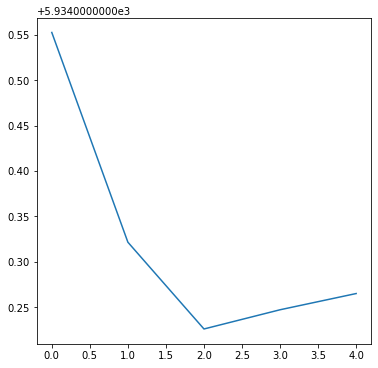

In [149]:
plt.plot(loss_rec)

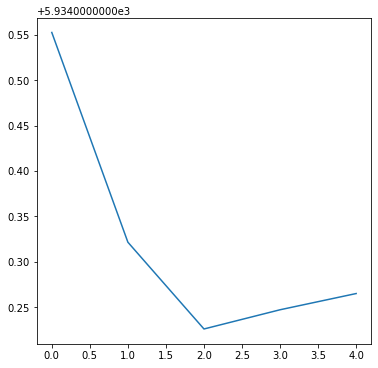

In [150]:
plt.plot(loss_rec)

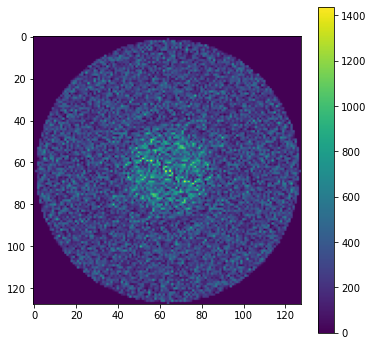

In [145]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

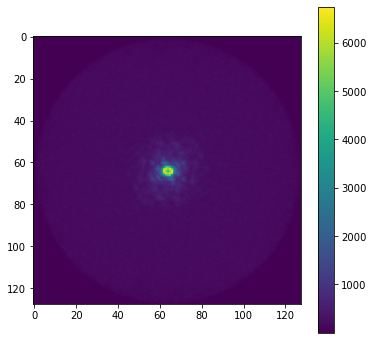

In [146]:
mip_z(np.fft.fftshift(np.abs(v_rec))); plt.colorbar()

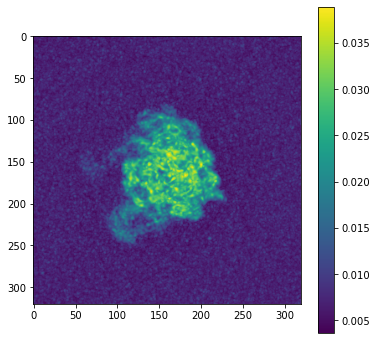

In [147]:
v_rec_l, x_grid_l = rescale_larger_grid(v_rec, x_grid, nx0)
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))
mip_z(vr_sgd)
plt.colorbar()

In [148]:
with mrcfile.new(f"{out_dir}/vr_rec_sgd.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))
    
    